# 套利分析

In [1]:
%matplotlib inline

In [2]:
import ccxt
import urllib.error
import requests
import asyncio
import time
import matplotlib.pyplot as plt  
import pandas as pd
import numpy as np

In [3]:
SYMBOL = 'ETH/BTC'

In [6]:
def get_all_exchange():
    return [getattr(ccxt,name)() for name in ccxt.exchanges]

In [7]:
def unzip(l): 
    return list(zip(*l))

In [8]:
def get_order_books(exchange_list, symbol):
    return {exchange.id: exchange.fetch_order_book(symbol) 
            for exchange in exchange_list}

In [9]:
def process_order_book(order_book):
    result = order_book.copy()
    result['asks'] = pd.DataFrame(data = {'price':list(unzip(order_book['asks']))[0], 
                                              'volume': list(unzip(order_book['asks']))[1]})
    result['bids'] = pd.DataFrame(data = {'price':list(unzip(order_book['bids']))[0], 
                                              'volume': list(unzip(order_book['bids']))[1]})
    return result

In [30]:
orders_list = get_order_books([ccxt.huobipro(), ccxt.okex()], SYMBOL)

In [38]:
orders_hobipro,  orders_okex = (process_order_book(orders_list['huobipro']), 
                               process_order_book(orders_list['okex']))

In [39]:
orders_hobipro['asks'].head()

,price,volume
0,0.080473,2.8372
1,0.080498,7.5100
2,0.080508,0.0935
3,0.080536,0.0187
4,0.080547,8.2700


In [40]:
orders_hobipro['bids'].head()

,price,volume
0,0.080430,0.2585
1,0.080429,1.3675
2,0.080427,0.0400
3,0.080413,0.0665
4,0.080412,0.0025


## 火币网和 OKEX 'ETH/BTC' 的交易盘

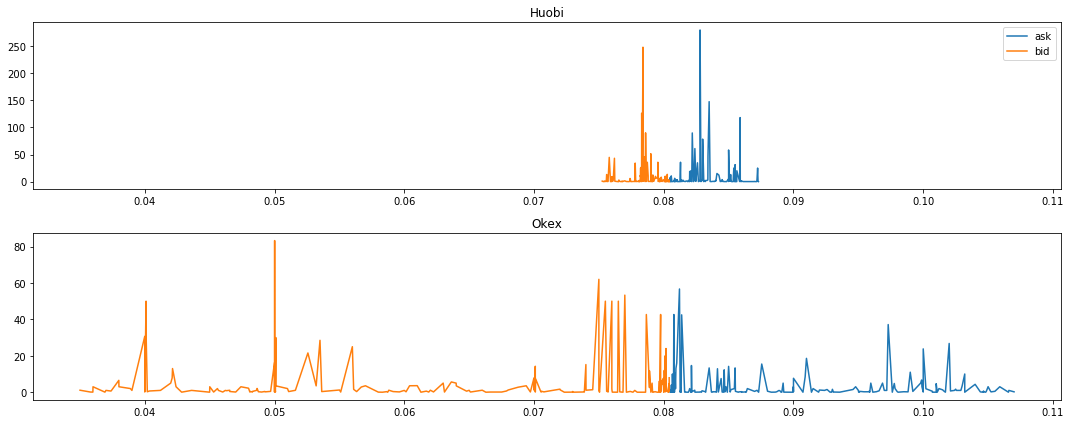

In [51]:
plt.figure(figsize=(15, 6)) 

ax = plt.subplot(212, )
plt.plot(orders_okex['asks']['price'],orders_okex['asks']['volume'], label = 'ask')  
plt.plot(orders_okex['bids']['price'],orders_okex['bids']['volume'], label = 'bid')  
#plt.legend()
plt.title('Okex')
plt.subplot(211,sharex=ax)
plt.plot(orders_hobipro['asks']['price'],orders_hobipro['asks']['volume'], label = 'ask')  
plt.plot(orders_hobipro['bids']['price'],orders_hobipro['bids']['volume'], label = 'bid')  
plt.legend()
plt.title('Huobi')
plt.tight_layout()
plt.show()  

## 计算两个交易所之间的价差

In [57]:
def difference_between_two_exchange(ex1, ex2, symbol,t = 10):
    
    ex1_bids = []
    ex2_bids = []
    ex1_asks = []
    ex2_asks = []
    for i in range(t):
        ex1_order_book = ex1.fetch_order_book(symbol)
        ex2_order_book = ex2.fetch_order_book(symbol)
        ex1_bids.append(ex1_order_book['bids'][0][0])
        ex2_bids.append(ex2_order_book['bids'][0][0])
        ex1_asks.append(ex1_order_book['asks'][0][0])
        ex2_asks.append(ex2_order_book['asks'][0][0])
        time.sleep(1)
    ex1_bids = np.array(ex1_bids)
    ex2_bids = np.array(ex2_bids) 
    ex1_asks = np.array(ex1_asks) 
    ex2_asks = np.array(ex2_asks)
    
    return {'dbids': ex1_bids - ex2_bids,
            'dasks': ex1_asks - ex2_asks,
            'dbidask':ex1_bids - ex2_asks,
            'daskbid':ex1_asks - ex2_bids}

## 将火币和 OKEX 的 ‘ETH/BTC’ 价格进行比较
时间为 10s

In [58]:
r = difference_between_two_exchange(ccxt.huobipro(), ccxt.okex(), SYMBOL, t = 10)

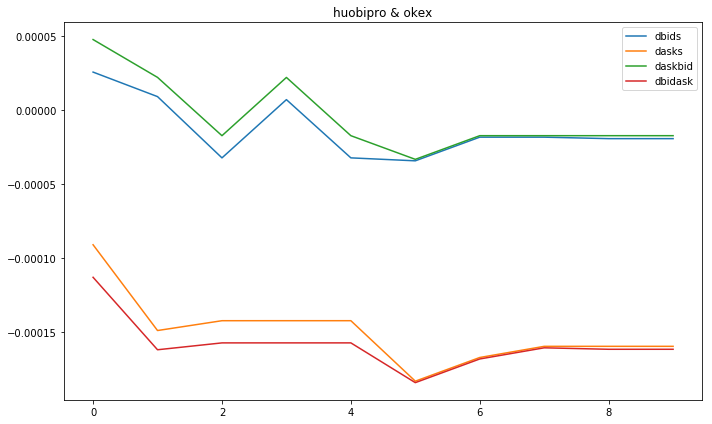

In [82]:
plt.figure(figsize=(10, 6)) 
plt.plot(r['dbids'], label = 'dbids')  
plt.plot(r['dasks'], label = 'dasks')  
plt.plot(r['daskbid'], label = 'daskbid')  
plt.plot(r['dbidask'], label = 'dbidask')  
plt.legend()
plt.title('huobipro & okex')
plt.tight_layout()
plt.show()

 ##  找到所有交易所中最便宜的卖价 和 最贵的买价
 没考虑时延和异步

In [13]:
def arbitrage(symbol, high_limit=0.2, low_limit=0.001 ):
    highest_bid = ('', 0)
    lowest_ask = ('', 1000)
    for exchange in get_all_exchange():
        try:
            orders = exchange.fetch_order_book(symbol)
            if orders['timestamp'] is None:
                continue
            e_bid = orders['bids'][0][0]
            e_ask = orders['asks'][0][0]
            if e_ask > high_limit or e_ask < low_limit:
                continue
            highest_bid = highest_bid if e_bid < highest_bid[1] else (exchange.id, e_bid)
            lowest_ask = lowest_ask if e_ask > lowest_ask[1] else (exchange.id, e_ask)
        except ccxt.AuthenticationError:
            pass
        except ccxt.ExchangeError:
            pass
        except requests.exceptions.HTTPError:
            pass
        except:
            pass
    return highest_bid, lowest_ask, (highest_bid[1]/lowest_ask[1]-1)

## 看一下 ETH 和 BTC 有没有套利空间

In [14]:
arbitrage(SYMBOL)

(('luno', 0.0812), ('therock', 0.08086231), 0.004176111219182266)

## 看看其它与比特币有关的交易对有没有套利空间

In [125]:
BTC_PAIRS = [symbol for symbol in ccxt.okex().loadMarkets().keys() 
             if symbol.startswith('BTC') or symbol.endswith('BTC')]

In [ ]:
# 这段代码得改成异步的，不然运行时间太长
# 得考虑一下查询频率 有些交易所有限制
#for symbol in BTC_PAIRS:
#    print(symbol)
#    print(arbitrage(symbol))